# Convolutional Neural Networks with Tensorflow

In [1]:
import addutils.toc ; addutils.toc.js(ipy_notebook=True)

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
from time import time
from IPython.display import Image, HTML, YouTubeVideo
import math
from addutils import css_notebook
from scipy import ndimage
from utilities import cifar10
import functools
import os
import pickle
from utilities.utils import lazy_property
from six.moves import cPickle
import json
import sys
css_notebook()

In [3]:
import bokeh.plotting as bk
from bokeh.io import push_notebook
from bokeh.layouts import gridplot
from bokeh.models import ColumnDataSource
bk.output_notebook()

Loading BokehJS ...

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

## 1 Convolutional Neural Network

Convolutional Neural Networks have gained much attention in the past few years, because they work very well in image processing, but nowadays are applyed to many Deep Learning tasks.

The fundamental difference between fully connected and convolutional neural networks is the connection between consecutive layers. In fully connected network each neuron is connected to all neuron in the previous layer. We sa that in previous notebook. In a convolutional layer instead each neuron is connected to a (typically small) number of neurons in the previous layer. Furthermore all neurons in the same layer are coonected to the previous layer in the same way, they have the exact same way, with the same weights. This operation is known as convolution and in a nutshell it means applying a small filter across an image.

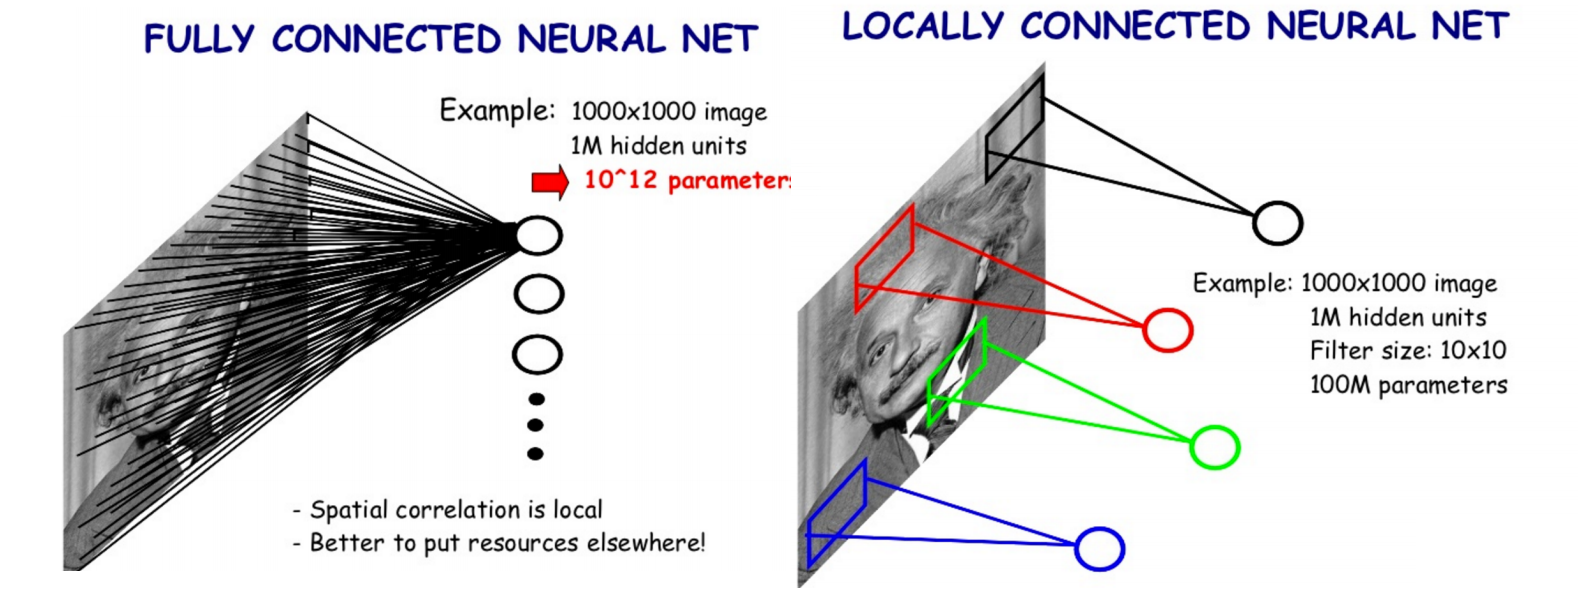

In [5]:
Image('images/WeightSharing.png')

In 1959 Hubel and Wiesel made experiments with cats and discovered how neurons in the visual cortex respond to stimulus, for example different kind of oriented edges, circles and so on. They found that nearby cells in the cortex correspond to nearby region in the visual field.

In [ ]:
Image('images/cat.jpg')  # Add cat.jpg to the repository!

Morover they found that neurons in the visult cortex have a hierarchical organization. Simple cells in early layers respond to simple forms and to light orientation. Connected on top of simple cells, more complex cells respond to light orientation and movement. Based on a similar intuition in 1998 the paper *Gradient-based learning applied to document recognition* by LeCun, Bottou, Bengio and Haffner, introduced the idea of convolutional neural networks, for digit recognition. The solution had good results but couldn't scale well. Fast forward to 2012, Alex Krizhevsky proposed a modern architecture for convolutional neural networks in the article *ImageNet Classification with Deep Convolutional Neural Networks* (Krizhevsky, Sutskever, Hinton). The networks was deeper and able to recognize bigger images. The two major keys that helped improve to previous models were basically two: 

 - large amount of data
 - use of GPU for parallel and faster computation

Convolutional neural networks use three basic ideas: **local receptive fields**, **shared weights**, and **pooling**. Let's look at each of these ideas in turn. 

#### 1.1 Local Receptive Fields and Shared Weights

In the fully-connected layers shown earlier, the inputs were depicted as a vertical line of neurons. In a convolutional net, it'll help to think instead of the inputs as a $28×28$ square of neurons, whose values correspond to the $28×28$ pixel intensities we're using as inputs:

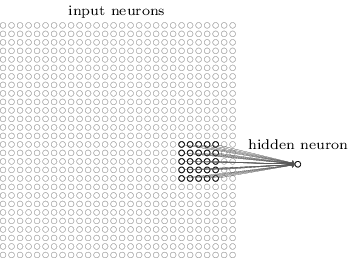

In [6]:
Image('images/receptive.png')

We will connect the input pixels to a layer of hidden neurons. But we don't connect every input pixel to every hidden neuron. Instead, we only make connections in small, localized regions of the input image.

To be more precise, each neuron in the first hidden layer will be connected to a small region of the input neurons, say, for example, a $5×5$ region, corresponding to $25$ input pixels. That region in the input image is called the **local receptive field** for the hidden neuron. I've shown the local receptive field being moved by one pixel at a time. In fact, sometimes a different stride length is used. For instance, we might move the local receptive field $2$ pixels to the right (or down), in which case we'd say a stride length of $2$ is used. 

Each hidden neuron has a bias and $5×5$ weights connected to its local receptive field. What I did not yet mention is that we're going to use the same weights and bias for each of the $24×24$ hidden neurons. This means that all the neurons in the first hidden layer detect exactly the same feature just at different locations in the input image. They **Share weights and biases**. For this reason, we sometimes call the map from the input layer to the hidden layer a **feature map**. We call the weights defining the feature map the shared weights. And we call the bias defining the feature map in this way the shared bias. The shared weights and bias are often said to define a kernel or filter.

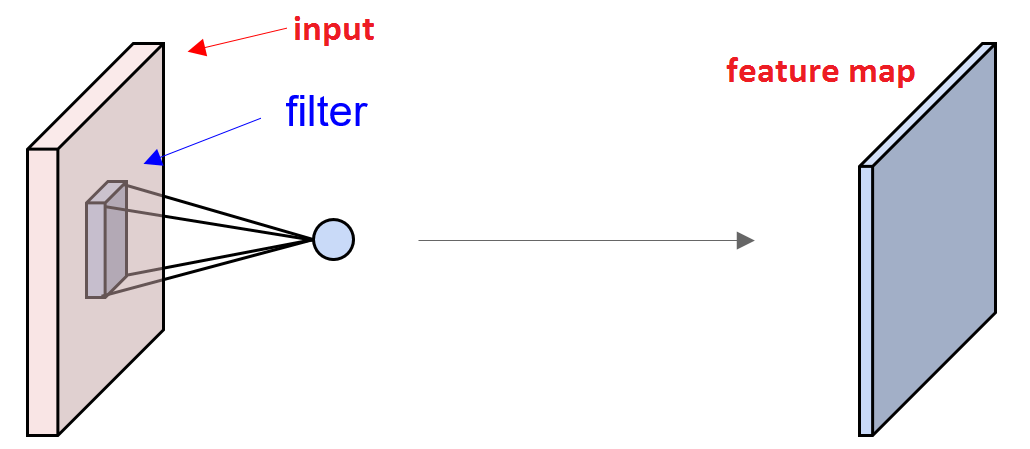

In [7]:
 Image('images/feature_map.png', width=700, height=700)

Why is a filter useful? In pre Deep Learning era, filters were handcrafted, then the activation map they produced were feeded as vectors to a classifier such as SVM. The goal was to devise more and more sophisticated kernels that helps the classifier to improve.

Let's see how filter works. We will implement two basic filters, a gaussian filter and a gabor filter.

In [8]:
ksize = 100
x = np.linspace(-3, 3, ksize)
y = np.exp(-np.power(x - 0, 2.) / (2 * np.power(1, 2.)))
fig = bk.figure(plot_width=400, plot_height=250, title=None)
fig.line(x, y)
bk.show(fig)

Now we can create a two-dimensional filter by multiplying a column vector gaussian by a row vector gaussian to create a matrix, that will be our filter.

In [9]:
gaussian_kernel = np.dot(np.atleast_2d(y).T, np.atleast_2d(y))
fig = bk.figure(x_range=(0, 1), y_range=(0, 1), 
                plot_width=300, plot_height=300, title=None)
fig.image(image=[gaussian_kernel], x=0, y=0, dw=1, dh=1, palette="Plasma256")
bk.show(fig)
print(gaussian_kernel.shape)

(100, 100)


In [10]:
img = plt.imread('images/camera.png')
fig = bk.figure(x_range=(0, 1), y_range=(0, 1), 
                plot_width=300, plot_height=300, title=None)
fig.image(image=[np.flip(img, axis=0)], x=0, y=0, dw=1, dh=1, palette="Greys256")
bk.show(fig)
print(img.shape)

(512, 512)


In [11]:
convolved = ndimage.convolve(img, gaussian_kernel, mode='constant', cval=0.0)
fig = bk.figure(x_range=(0, 1), y_range=(0, 1), 
                plot_width=300, plot_height=300, title=None)
fig.image(image=[np.flip(convolved, axis=0)], x=0, y=0, dw=1, dh=1, palette="Greys256")
bk.show(fig)

In [12]:
x = np.linspace(-3, 3, ksize)
y = np.sin(x)
fig = bk.figure(plot_width=400, plot_height=250, title=None)
fig.line(x, y)
bk.show(fig)

In [13]:
ones = np.ones((1, ksize))
wave = np.dot(np.atleast_2d(y).T, ones)
gabor_filter = np.dot(wave, gaussian_kernel)
fig = bk.figure(x_range=(0, 1), y_range=(0, 1), 
                plot_width=300, plot_height=300, title=None)
fig.image(image=[gabor_filter], x=0, y=0, dw=1, dh=1, palette="Plasma256")
bk.show(fig)
print(gaussian_kernel.shape)

(100, 100)


In [14]:
convolved = ndimage.convolve(img, gabor_filter, mode='constant', cval=0.0)
fig = bk.figure(x_range=(0, 1), y_range=(0, 1), 
                plot_width=300, plot_height=300, title=None)
fig.image(image=[np.flip(convolved, axis=0)], x=0, y=0, dw=1, dh=1, palette="Greys256")
bk.show(fig)

A big advantage of sharing weights and biases is that it greatly reduces the number of parameters involved in a convolutional network. For each feature map we need $25=5×5$ shared weights, plus a single shared bias. So each feature map requires $26$ parameters. If we have $32$ feature maps that's a total of $32×26=832$ parameters defining the convolutional layer. By comparison, suppose we had a fully connected first layer, with $784=28×28$ input neurons, and a relatively modest $32$ hidden neurons, as we used in many of the examples earlier in the book. That's a total of $784×32$ weights, plus an extra $32$ biases, for a total of $25,088$ parameters. In other words, the fully-connected layer would have more than $30$ times as many parameters as the convolutional layer.

Now suppose that the image is not flat and that is has 3 color channels. Each filter must account for the channels as well. 

Now suppose that we have a $7x7$ image and a $3x3$ filter the output will be a $5x5$ activation map. If we use a stride of $2$ the output will be a $3x3$ activation. If we apply a stride of $3$ the filter doesn't fit. In practice the resulting image size is given by $(N-F)\, /\, \text{stride} + 1$. In order to maintain the same image size, it is usual practice to apply padding. In pratice we add pixels to the side of the image. For example with stride one we pad with one pixel (we set it to $0$) and the output size is the same as input size ($7x7$)

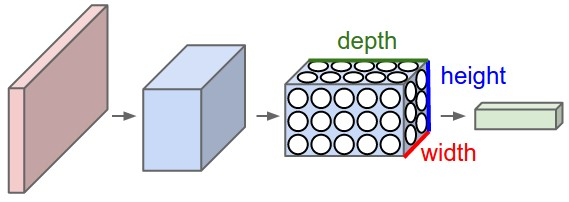

In [15]:
Image('images/cnn.jpeg')

Suppose input volume is $32x32x3$ and we have $10$ $5x5$ filters with stride $1$, pad $2$, what is the otput volume size? What is the number of parameters in this layer?

#### 1.2 Pooling layers

In addition to the convolutional layers just described, convolutional neural networks also contain pooling layers. Pooling layers are usually used immediately after convolutional layers. What the pooling layers do is simplify the information in the output from the convolutional layer. Pool layers perform a downsampling operation along the spatial dimensions (width, height), resulting in volume such as $[14x14x32]$.

Max pooling outputs the maximum of the input in each region of a predefined size (here $2×2$). The stride argument controls by how much we slide the pooling grids across the picture. Setting the pooling to a $2×2$ grid with strides equal $2$ means that the output of the pooling will be exactly one-half of the height and width of the original, and in total one-quarter of the size.

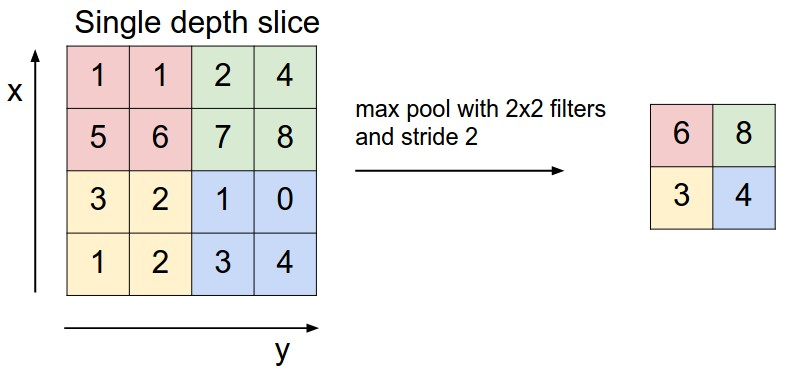

In [16]:
Image('images/maxpool.jpeg', width=600, height=600)

The main motivations for this function are both technical and theoretical. For the technical aspect, pooling reduces the size of the data to be processed and in turn it reduces the number of overall parameters in the model, especially if we use fully connected layers after the convolutional ones. The theoretical aspect instead is that we would like the feature maps not to care about small changes in position in an image. For instance, a feature looking for eyes in the top-right part of an image should not change too much if we move the camera a bit to the right when taking the picture, moving the eyes slightly to the center of the image. Aggregating the feature maps spatially allows the model to overcome such variability, capturing some form of invariance. Pooling works only spatially it does not reduce depth. For example if we apply pooling at a feature map with size $224x224x64$ we get $112x112x64$

The backward pass for a max(x, y) operation only routes the gradient to the input that had the highest value. During the forward pass of a pooling layer it is common to keep track of the index of the max activation so that gradient routing is efficient during backpropagation.

### 1.3 Visualization

Now let's see how a Convolutional Neural Networks sees the world.

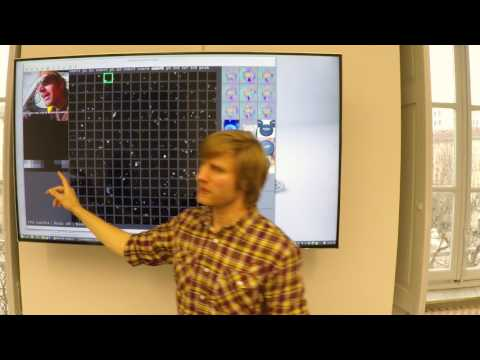

In [17]:
YouTubeVideo('wO6AAq3uE-w', width=600, height=450)

### 1.4 Regularization

There are various way to regularize a Neural Network, we introduce some of the most used method here. Standard method to reduce weights magnitude such applying a norm can be used in this context. However there are few methods that are more suitable. One of the simplest and widely used methods for regularization is **early stopping**.

In [ ]:
Image('images/early_stopping.png')

In practice at every iteration it controls the error on the validation set and stops learning when the error stops improving, while training error continue to decrease.

A recent algorithms for regularization is dropout. It tries to prevent co-adaptation of neurons by shutting some neurons off during training, while in prediction it uses its full capacity. Ideally when we train a neural network, we would like each neuron to operate as an independent feature detector. If some neurons starts to detecting the same feature repeatedly (co-adaptation), the network is not efficiently using its power. It is wasting time computing the activation for redundant neurons that are all doing the same thing. 

In [ ]:
Image('images/dropout.jpeg')

One of the most successful recent normalization technique is **Batch Normalization**. It tries to reduce Internal Covariate Shift: each layer’s inputs changes during training, as the parameters of the previous layers change. The change in the distributions of layers’ inputs presents a problem because the layers need to continuously adapt to the new distribution. Reduce Internal Covariate Shift: normalization is a part of the model architecture and it is performed for each training mini-batch. Whitening the inputs to each layer, it is similar to have fixed distributions of inputs that would remove the effects of ICS.

## 2 CNN for MNIST

### 2.1 The Data

In [18]:
mnist = input_data.read_data_sets('example_data/MNIST_data', one_hot=True)

Extracting example_data/MNIST_data/train-images-idx3-ubyte.gz
Extracting example_data/MNIST_data/train-labels-idx1-ubyte.gz
Extracting example_data/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting example_data/MNIST_data/t10k-labels-idx1-ubyte.gz


In [19]:
# The MNIST dataset has 10 classes, representing the digits 0 through 9.
NUM_CLASSES = 10

# The MNIST images are always 28x28 pixels.
IMAGE_SIZE = 28
IMAGE_PIXELS = IMAGE_SIZE * IMAGE_SIZE

### 2.2 The Model

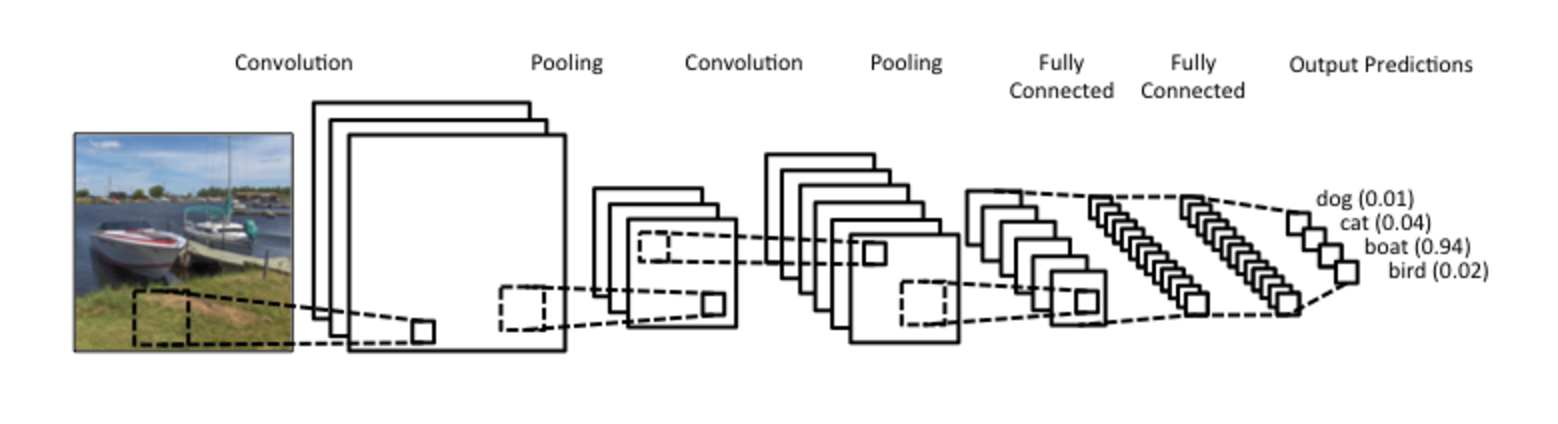

In [20]:
Image('images/tf_mnist.png')

The following code defines the usual placeholder for the input examples and associated labels, as well as two helper functions to construct weight variables.

In [21]:
x = tf.placeholder(tf.float32, shape=[None, 784])
y_ = tf.placeholder(tf.float32, shape=[None, 10])

**TODO:** use get_variable 

In [22]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

In [23]:
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1], padding='SAME')


Reshape of the input so it resemble a 2D image.

In [24]:
x_image = tf.reshape(x, [-1,28,28,1])

We can now implement our first layer. It will consist of convolution, followed by max pooling. The convolutional will compute $32$ features for each $5x5$ patch. Its weight tensor will have a shape of $[5, 5, 1, 32]$. The first two dimensions are the patch size, the next is the number of input channels, and the last is the number of output channels. We will also have a bias vector with a component for each output channel. 

In [25]:
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])

We then convolve x_image with the weight tensor, add the bias, apply the ReLU function, and finally max pool.

In [26]:
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

In order to build a deep network, we stack several layers of this type. The second layer will have 64 features for each 5x5 patch.

In [27]:
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

Last but not least, a fully connected layer that is able to combine previous layers

In [28]:
W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

One thing to mention is regularization we applied dropout to prevent overfitting. 

In [29]:
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

Last stage compute probability and assign to each example a class.

In [30]:
W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])

y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

In [31]:
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=y_conv, labels=y_))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

### 2.3 Training and Evaluation

In [32]:
sess = tf.InteractiveSession()

In [33]:
STEPS = 1000
BATCH_SIZE = 128

In [34]:
sess.run(tf.global_variables_initializer())

for i in range(STEPS):
    batch = mnist.train.next_batch(BATCH_SIZE)
    if i%100 == 0:
        train_accuracy = accuracy.eval(feed_dict={x:batch[0], 
                                                  y_: batch[1], 
                                                  keep_prob: 1.0})
        print("step %d, training accuracy %g"%(i, train_accuracy))
    train_step.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})

step 0, training accuracy 0.148438
step 100, training accuracy 0.890625
step 200, training accuracy 0.882812
step 300, training accuracy 0.953125
step 400, training accuracy 0.992188
step 500, training accuracy 0.984375
step 600, training accuracy 0.953125
step 700, training accuracy 0.953125
step 800, training accuracy 0.945312
step 900, training accuracy 0.984375


In [35]:
print('test accuracy {}'.format(accuracy.eval(feed_dict={x: mnist.test.images, 
                                                  y_: mnist.test.labels, 
                                                  keep_prob: 1.0})))

test accuracy 0.9749000072479248


In [36]:
sess.close()

## 3 Advanced Models

### 3.1 CNN for CIFAR 10

CIFAR10 is another dataset used to benchmarking computer vision and machine learning algorithms. CIFAR10 is a set of $60\,000$ color images of size $32×32$ pixels, each belonging to one of ten categories: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, and truck. Unlike MNIST the images are RGB. We are going to use an utility function to download the cifare dataset. The dataset is approximately 170 MByte.

In [37]:
cifar10.data_path = "example_data/CIFAR-10/"
cifar10.maybe_download_and_extract()

Data has apparently already been downloaded and unpacked.


In [38]:
class_names = cifar10.load_class_names()
images_train, cls_train, labels_train = cifar10.load_training_data()
images_test, cls_test, labels_test = cifar10.load_test_data()

Loading data: example_data/CIFAR-10/cifar-10-batches-py/batches.meta
Loading data: example_data/CIFAR-10/cifar-10-batches-py/data_batch_1
Loading data: example_data/CIFAR-10/cifar-10-batches-py/data_batch_2
Loading data: example_data/CIFAR-10/cifar-10-batches-py/data_batch_3
Loading data: example_data/CIFAR-10/cifar-10-batches-py/data_batch_4
Loading data: example_data/CIFAR-10/cifar-10-batches-py/data_batch_5
Loading data: example_data/CIFAR-10/cifar-10-batches-py/test_batch


In [39]:
class_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [40]:
print("Training set: {}".format(len(images_train)))
print("Test set: {}".format(len(images_test)))

Training set: 50000
Test set: 10000


This is an helper function for taking random batches from the training set.

In [41]:
def random_batch(batch_size):
    # Number of images in the training-set.
    num_images = len(images_train)

    # Create a random index.
    idx = np.random.choice(num_images,
                           size=batch_size,
                           replace=False)

    # Use the random index to select random images and labels.
    x_batch = images_train[idx, :, :, :]
    y_batch = labels_train[idx, :]

    return x_batch, y_batch

In [42]:
def plot_images(images, cls_true, cls_pred=None, dim=9):
    fig, axes = plt.subplots(int(np.sqrt(dim)), int(np.sqrt(dim)), figsize=(9,9))
    fig.subplots_adjust(hspace=.6, wspace=.3)
    
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i, :, :, :])    
        # Name of the true class.
        cls_true_name = class_names[cls_true[i]]
        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true_name)
        else:
            # Name of the predicted class.
            cls_pred_name = class_names[cls_pred[i]]
            xlabel = "True: {0}\nPred: {1}".format(cls_true_name, cls_pred_name)

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
  
    #fig.show()

Here we have an example of a 9 images sampled from the training set, with corresponding label.

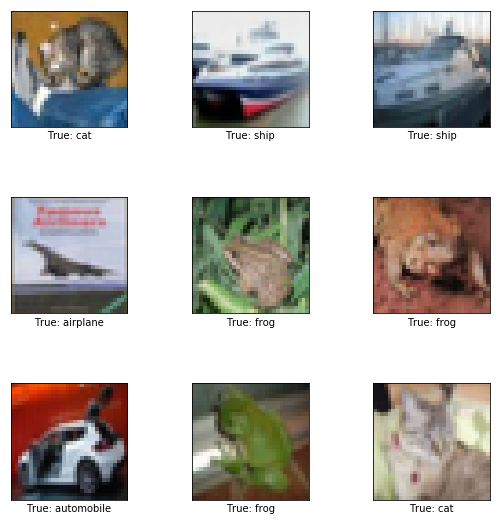

In [43]:
# Get the first images from the test-set.
images = images_test[0:9]
# Get the true classes for those images.
cls_true = cls_test[0:9]
# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)

In [44]:
def conv_layer(x, shape):
    W_conv = weight_variable(shape)
    b_conv = bias_variable([shape[-1]])
    return tf.nn.relu(conv2d(x, W_conv) + b_conv)

In [45]:
def full_layer(h, shape):
    W_fc = weight_variable(shape)
    b_fc = bias_variable([shape[-1]])

    h_flat = tf.reshape(h, [-1, shape[0]])
    return tf.matmul(h_flat, W_fc) + b_fc

In [46]:
tf.reset_default_graph()

x = tf.placeholder(tf.float32, shape=[None, 32, 32, 3])
y_ = tf.placeholder(tf.float32, shape=[None, 10])
keep_prob = tf.placeholder(tf.float32)
global_step = tf.Variable(initial_value=0, name='global_step', trainable=False)

conv1 = conv_layer(x, shape=[5, 5, 3, 32])
conv1_pool = max_pool_2x2(conv1)

conv2 = conv_layer(conv1_pool, shape=[5, 5, 32, 64])
conv2_pool = max_pool_2x2(conv2)
conv2_flat = tf.reshape(conv2_pool, [-1, 8 * 8 * 64])

full_1 = tf.nn.relu(full_layer(conv2_flat, [8 * 8 * 64, 1024]))
full1_drop = tf.nn.dropout(full_1, keep_prob=keep_prob)

y_conv = full_layer(full1_drop, [1024, 10])

cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=y_conv, 
                                                                       labels=y_))
train_step = tf.train.AdamOptimizer(1e-3).minimize(cross_entropy, global_step=global_step)

correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

saver = tf.train.Saver()

In [47]:
def optimize(sess, steps, batch_size, save_dir='temp/cifar_models/cifar_base', prob=0.5):
    save_path = os.path.join(save_dir, 'checkpoint')
    try:
        print("Trying to restore last checkpoint")
        last_chk_path = tf.train.latest_checkpoint(checkpoint_dir=save_dir)
        saver.restore(sess, save_path=last_chk_path)
        print("Restored checkpoint from:", last_chk_path)
    except:
        print("Failed to restore checkpoint. Initializing variables instead.")
        sess.run(tf.global_variables_initializer())   
        
    for i in range(steps):
        batch = random_batch(batch_size)
        global_i, _ = sess.run([global_step, train_step], feed_dict={x: batch[0], 
                                                                     y_: batch[1], 
                                                                     keep_prob: prob})
        if (global_i % 100 == 0)  or (i == steps - 1):
            train_accuracy = sess.run(accuracy, feed_dict={x:batch[0],
                                                           y_: batch[1],
                                                           keep_prob: 1.0})
            print("step {}, training accuracy {}".format(global_i, train_accuracy))
            
        if (global_i % 1000 == 0)  or (i == steps - 1):
            saver.save(sess, save_path=save_path, global_step=global_step)
            print("saved checkpoint")

    acc = sess.run(accuracy, feed_dict={x: images_test, y_: labels_test, keep_prob: 1.0})
    print('test accuracy {}'.format(acc))

In [48]:
STEPS = 1000
BATCH_SIZE = 128

In [50]:
t0 = time()
with tf.Session() as sess:
    optimize(sess, STEPS, BATCH_SIZE)
print('optimization time: {}'.format(time()-t0))

Trying to restore last checkpoint
Failed to restore checkpoint. Initializing variables instead.
step 100, training accuracy 0.421875
step 200, training accuracy 0.484375
step 300, training accuracy 0.5546875
step 400, training accuracy 0.5078125
step 500, training accuracy 0.609375
step 600, training accuracy 0.5703125
step 700, training accuracy 0.671875
step 800, training accuracy 0.6953125
step 900, training accuracy 0.734375
step 1000, training accuracy 0.6953125
saved checkpoint
test accuracy 0.5909000039100647
optimization time: 13.034542560577393


### 3.2 Quick detours

#### 3.2.1 TensorFlow file format: `TFRecord`

TensorFlow has a built-in file format designed to keep binary data and label data in the same file. The format is called TFRecord and requires a preprocessing step to convert images to a TFRecord format before training. TFRecord files are protobuf formatted files.

>Protocol buffers are a language-neutral, platform-neutral extensible mechanism for serializing structured data. 

They are great for use as a preprocessed format because they aren’t compressed and can be loaded into memory quickly. 

In the code, the images are loaded into memory and converted into an array of bytes. The bytes are then added to the `tf.train.Example` file which are serialized (`SerializeToString`) before storing to disk. Serialization is a way of converting the in memory object into a format safe to be transferred to a file. In the code that follows, few other information are added to each Example, the label of the image, the format of the image and its width and height.

Now the TFRecord file can be used for loading images and labels during trainig. This will save time from loading the input image and its corresponding label separately.

In [51]:
# The number of training files.
_NUM_TRAIN_FILES = 5

# The height and width of each image.
_IMAGE_SIZE = 32

# The names of the classes.
_CLASS_NAMES = [
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck',
]

In [52]:
def int64_feature(values):
  """Returns a TF-Feature of int64s.

  Args:
    values: A scalar or list of values.

  Returns:
    A TF-Feature.
  """
  if not isinstance(values, (tuple, list)):
    values = [values]
  return tf.train.Feature(int64_list=tf.train.Int64List(value=values))


def bytes_feature(values):
  """Returns a TF-Feature of bytes.

  Args:
    values: A string.

  Returns:
    A TF-Feature.
  """
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[values]))


def float_feature(values):
  """Returns a TF-Feature of floats.

  Args:
    values: A scalar of list of values.

  Returns:
    A TF-Feature.
  """
  if not isinstance(values, (tuple, list)):
    values = [values]
  return tf.train.Feature(float_list=tf.train.FloatList(value=values))

In [53]:
def _add_to_tfrecord(filename, tfrecord_writer, offset=0):
  """Loads data from the cifar10 pickle files and writes files to a TFRecord.

  Args:
    filename: The filename of the cifar10 pickle file.
    tfrecord_writer: The TFRecord writer to use for writing.
    offset: An offset into the absolute number of images previously written.

  Returns:
    The new offset.
  """
  with tf.gfile.Open(filename, 'rb') as f:
    if sys.version_info < (3,):
      data = cPickle.load(f)
    else:
      data = cPickle.load(f, encoding='bytes')

  images = data[b'data']
  num_images = images.shape[0]

  images = images.reshape((num_images, 3, 32, 32))
  labels = data[b'labels']

  with tf.Graph().as_default():
    image_placeholder = tf.placeholder(dtype=tf.uint8)
    encoded_image = tf.image.encode_png(image_placeholder)

    with tf.Session('') as sess:

      for j in range(num_images):
        sys.stdout.write('\r>> Reading file [%s] image %d/%d' % (
            filename, offset + j + 1, offset + num_images))
        sys.stdout.flush()

        image = np.squeeze(images[j]).transpose((1, 2, 0))
        label = labels[j]

        png_string = sess.run(encoded_image,
                              feed_dict={image_placeholder: image})

        example = tf.train.Example(features=tf.train.Features(feature={
            'image/encoded': bytes_feature(png_string),
            'image/format': bytes_feature(b'png'),
            'image/class/label': int64_feature(label),
            'image/height': int64_feature(_IMAGE_SIZE),
            'image/width': int64_feature(_IMAGE_SIZE),
        }))
        tfrecord_writer.write(example.SerializeToString())
  return offset + num_images

In [54]:
def convert_to_tfrecord(dataset_dir):
    if not os.path.isdir(dataset_dir):
        print('Dataset directory does not exists, exiting!')
        return

    _filename = os.path.basename(dataset_dir.strip('/'))
    training_filename = _filename.lower()+'_train.tfrecord'
    testing_filename = _filename.lower()+'_test.tfrecord'

    training_path = os.path.join(dataset_dir, training_filename)
    testing_path = os.path.join(dataset_dir, testing_filename)
    if os.path.isfile(training_path) and os.path.isfile(testing_path):
        print('Dataset files already exist, exiting!')
        return

    # First, process the training data:
    with tf.python_io.TFRecordWriter(training_path) as tfrecord_writer:
        offset = 0
        for i in range(_NUM_TRAIN_FILES):
            filename = os.path.join(dataset_dir,
                                    'cifar-10-batches-py',
                                    'data_batch_%d' % (i + 1))  # 1-indexed.
            offset = _add_to_tfrecord(filename, tfrecord_writer, offset)

    # Next, process the testing data:
    with tf.python_io.TFRecordWriter(testing_path) as tfrecord_writer:
        filename = os.path.join(dataset_dir,
                                'cifar-10-batches-py',
                                'test_batch')
        _add_to_tfrecord(filename, tfrecord_writer)

    # Finally, write the labels file:
    labels_to_class_names = dict(zip(range(len(_CLASS_NAMES)), _CLASS_NAMES))
    with open(os.path.join(dataset_dir, 'labels.txt'), 'w') as f:
        json.dump(labels_to_class_names, f)
    print('\nFinished converting the Cifar10 dataset!')

In [55]:
convert_to_tfrecord('example_data/CIFAR-10/')

Dataset files already exist, exiting!


#### 3.2.2 build complex data pipelines with `tf.data`

`tf.data` is a library that helps defining input pipelines. So far we have used placeholder as the input methods for our models. Modern models need faster input pipelines, but it is not only about performance, we want an easier method to get data into TensorFlow. For this reason it has been created the **Dataset** interface. A Dataset is a collection of elements.  The **Iterator** interface provides sequential access to Dataset elements. 

Deep Learning relies on huge datasets to train models to high accuracy, however modern accelerators are very thirsty. Architectures like NVIDIA’s Volta and Cloud TPUs are so much faster than what we had a couple years ago, and they demand much higher throughput from the input pipeline to keep them saturated. But it not just a question of performance, input data pipelines to TensorFlow should be easier to implement.

Previously, there were essentially two options: the feed_dict mechanism, which effectively puts all input processing outside TensorFlow, in Python. This method hast all the flexibility of Python, which makes it easy to work with arbitrary data format, but the performance can be poor: users often end up running processing their input data in a single thread and on the critical path. The GPU could use that time to do something more useful.

The second option is to move your processing into C++ TensorFlow ops, and string them together with TensorFlow’s producer/consumer queues. This APIs build a little queuing network that gives parallelism and it decreases the amount of time wasted copying data into placeholders. However it has a big drawback, the queue remove control from Python. The users need to start a queue runner that forks off Python threads to run little graphs that move elements between queues. It relies on the execution of a complex concurrent Python program to keep your queues full, and the Global Interpreter Lock puts a hard limit on the number of records you can process per second. Moreover queues are conceptually hard to use, for instance you cannot change the input source at runtime.

Input pipelines are modeled like lazy lists, because the entire dataset might be too large to be read all at once. It is possible to use `map` functions to preprocess.

It is possible to create a dataset from one or more tensors: 
 - dataset = tf.data.Dataset.from_tensor_slices((features, labels))
 - dataset = tf.data.Dataset.from_generator(gen, output_types, output_shapes)

or from files:
 - tf.data.TextLineDataset(filenames)
 - tf.data.FixedLengthRecordDataset(filenames)
 - tf.data.TFRecordDataset(filenames)
 
Then create an iterator to go through samples in the dataset:
 - iterator = dataset.make_one_shot_iterator()
 - iterator = dataset.make_initializable_iterator()


In [56]:
MAX_ELEMENTS = 20

def gen():
    for i in range(MAX_ELEMENTS):
        yield i

dataset = tf.data.Dataset.from_generator(gen, tf.int32)

In [57]:
NUM_EPOCHS = 3
BATCH_SIZE = 15
dataset = dataset.map(lambda x: x*2)
dataset = dataset.repeat(NUM_EPOCHS)
dataset = dataset.batch(BATCH_SIZE)

In [58]:
iterator = dataset.make_one_shot_iterator()
next_element = iterator.get_next()

In [59]:
with tf.Session() as sess:
    for _ in range((MAX_ELEMENTS * NUM_EPOCHS) // BATCH_SIZE):
        print(sess.run(next_element))

[ 0  2  4  6  8 10 12 14 16 18 20 22 24 26 28]
[30 32 34 36 38  0  2  4  6  8 10 12 14 16 18]
[20 22 24 26 28 30 32 34 36 38  0  2  4  6  8]
[10 12 14 16 18 20 22 24 26 28 30 32 34 36 38]


For the purpose of this notebook we will create a dataset from tf record files.

In [60]:
dataset = tf.data.TFRecordDataset('example_data/CIFAR-10/cifar-10_train.tfrecord')

In [61]:
for example in tf.python_io.tf_record_iterator("example_data/CIFAR-10/cifar-10_train.tfrecord"):
    result = tf.train.Example.FromString(example)
    
print(result)

features {
  feature {
    key: "image/class/label"
    value {
      int64_list {
        value: 1
      }
    }
  }
  feature {
    key: "image/encoded"
    value {
      bytes_list {
        value: "\211PNG\r\n\032\n\000\000\000\rIHDR\000\000\000 \000\000\000 \010\002\000\000\000\374\030\355\243\000\000\tHIDATH\211-\226Yo]\347y\205\337o\332\343\331g\"y\016G\311\226%[\026\251Z\266j9n\"\273M\0024@\020\240\375\251\001\202\3666@\320\026q\022G\326`\322\220%\2234\3113\317{\370\3667\274o/\234u\265.\037`\001\017\026\273\276^\204Q\204\004\036I\t\026(.\005\007 \347\320X\347\034\002\020c@\210\326\371\332:c\235\363\210\210\000\2143\3019\007\301\031\010\316\030#\'\245\364\210\336y!\270\224\214\001\361Z\227\202sBb\004\210\204HH\364S\361\004H\340\211<\242\363d\035:\207\210\004\000\2141\316\376\021\301\205\020\234\003\":\006(8\004J\004R\004J\346\371FV\253y#M\220)b\214\220\264An\010\200\034\222\363H\210\014\310\023z\213\306z\343\254\363\236q\316\2011\006\034\2101p\316\001\021\207\177\220WU%\270\210\

In [62]:
def _parse_function(example_proto):
    features = {"image/encoded": tf.FixedLenFeature((), tf.string, default_value=""), 
                "image/class/label": tf.FixedLenFeature((), tf.int64, default_value=0)}
    parsed_features = tf.parse_single_example(example_proto, features)
    return (tf.image.convert_image_dtype(tf.image.decode_png(parsed_features["image/encoded"]), 
                                         dtype=tf.float32), 
            parsed_features["image/class/label"])

At first, the file is loaded in the same way as any other file. The main difference is that the file is then read using a TFRecordReader. Instead of decoding the image, the TFRecord is parsed tf.parse_single_example and then the image is read as png (tf.decode_png).

TFRecord record files support multiple examples being written to them. It’d be safe to have a single TFRecord file which stores an entire training set but splitting up the files doesn’t hurt. 

Creating a file that stores both the raw image data and the expected output label will save complexities during training. It’s not required to use TFRecord files but it’s highly recommend when working with images. If it doesn’t work well for a workflow, it’s still recommended to preprocess images and save them before training. Manipulating an image each time it’s loaded is not recommended.

In [63]:
dataset = dataset.map(_parse_function)

In [64]:
batch_size = 16
dataset = dataset.batch(batch_size)

In [65]:
iterator = dataset.make_one_shot_iterator()
images, labels = iterator.get_next()

In [66]:
with tf.Session() as sess:
    image, label = sess.run([images, labels])

In [67]:
print(image.shape)
print(label.shape)

(16, 32, 32, 3)
(16,)


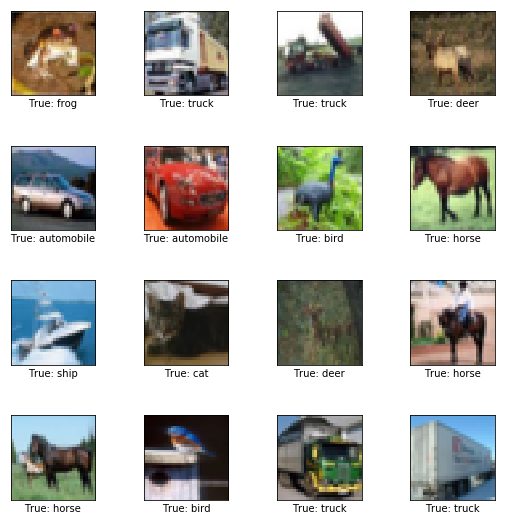

In [68]:
plot_images(image, label, dim=batch_size)

#### 3.2.2 Process Images with `tf.image`

TensorFlow provides Ops to process images. This is useful to build complex pipelines. We have seen an operetaion to convert data from png to numeric format. As we have seen in previous notes, one method to increase accuracy is to **augment** data by transforming images. For convenience TensorFlow has a **tf.image** library for image processing. The library offers various function for:

- encoding/deconding
- cropping
- resizing
- flipping, rotating and transposing
- image adjustments (color, saturation and many more)

Please refer to [this page](https://www.tensorflow.org/api_guides/python/image) for a list of available functions. In following code we create a parser generator, that, given a tf.image operation returns a parser function that applies the operation to a single image, like in previous tf.data example. 

In [69]:
def parse_function_generator(fun,*args):
    def _parse_function_augmented(example_proto):
        features = {"image/encoded": tf.FixedLenFeature((), tf.string, default_value=""), 
                "image/class/label": tf.FixedLenFeature((), tf.int64, default_value=0)}
        parsed_features = tf.parse_single_example(example_proto, features)
        images = parsed_features["image/encoded"] 
        labels = parsed_features["image/class/label"]
        images = tf.image.convert_image_dtype(tf.image.decode_png(images), dtype=tf.float32)
        images = fun(images, *args)
        return images, labels
    return _parse_function_augmented

#### 3.2.3 Simplify code with `tf.layers`

This library offers an abstraction for building the layers of a Neural Network. For example the code for a convolutional layer is simply:

```python
conv1 = tf.layers.conv2d(inputs=self.img,
                                  filters=32,
                                  kernel_size=[5, 5],
                                  padding='SAME',
                                  activation=tf.nn.relu,
                                  name='conv1')
```
We will use `tf.layers` combined with an object abstraction like we used for mnist in the previous notebook.

### 3.3 CNN for CIFAR10: the Model

In [70]:
class CnnModel:
    def __init__(self, 
                 cnn_layers, 
                 fc_layers, 
                 train_file,
                 test_file,
                 batch_size=128, 
                 save_dir='temp/cifar_models/cifar_obj', 
                 shape=(32, 32, 3),
                 n_classes=10, 
                 augmented=[]):
        self.save_dir = save_dir
        self.save_path = os.path.join(save_dir, 'checkpoint')
        self.batch_size = batch_size
        self.n_classes = n_classes
        self.height, self.width, self.channels = shape
        self.train_file = train_file
        self.test_file = test_file
        self.augmented = [parse_function_generator(*f) for f in augmented]
        self.training_iterator, self.validation_iterator = self._init_dataset()
        
        self.cnn_layers = cnn_layers
        self.fc_layers = fc_layers
        self.keep_prob = tf.placeholder(tf.float32)
        self.global_step = tf.Variable(initial_value=0, 
                                       name='global_step', 
                                       trainable=False) # use get_variable
        self._layers = []
        self._last_layer = None
        self.sess = tf.Session()     
        self.training_handle = self.sess.run(self.training_iterator.string_handle())
        self.validation_handle = self.sess.run(self.validation_iterator.string_handle())
        self.cost
        self.accuracy
        self.optimize
        self.prediction
        self.merged = tf.summary.merge_all()
        self.train_writer = tf.summary.FileWriter(os.path.join(self.save_dir, 'train'),
                                                  self.sess.graph)
        self.test_writer = tf.summary.FileWriter(os.path.join(self.save_dir, 'test'))
        self.saver = tf.train.Saver()
        try:
            print("Trying to restore last checkpoint")
            last_chk_path = tf.train.latest_checkpoint(checkpoint_dir=self.save_dir)
            self.saver.restore(self.sess, save_path=last_chk_path)
            print("Restored checkpoint from:", last_chk_path)
        except:
            print("Failed to restore checkpoint. Initializing variables instead.")
            self.sess.run(tf.global_variables_initializer())   

    def _dataset(self, training=True):
        if training:
            filename = self.train_file
        else:
            filename = self.test_file
        dataset = tf.data.TFRecordDataset(filename)
        dataset = dataset.map(_parse_function, num_parallel_calls=64)
        if training:
            for f in self.augmented:
                augmented = tf.data.TFRecordDataset(filename)
                augmented = augmented.map(f, num_parallel_calls=64)
                dataset = dataset.concatenate(augmented)
        dataset = dataset.shuffle(10000)
        dataset = dataset.batch(self.batch_size)
        dataset = dataset.prefetch(1)
        return dataset
        
    def _init_dataset(self):
        self.handle = tf.placeholder(tf.string, shape=None)
        training_dataset = self._dataset()
        validation_dataset = self._dataset(training=False)
        iterator = tf.data.Iterator.from_string_handle(self.handle, 
                                                       training_dataset.output_types, 
                                                       training_dataset.output_shapes)
        self.images, self.labels = iterator.get_next()
        training_iterator = training_dataset.make_initializable_iterator()
        validation_iterator = validation_dataset.make_initializable_iterator()
        return training_iterator, validation_iterator
    
    @lazy_property
    def prediction(self):
        return tf.nn.softmax(self.forward)

    def fully_connected(self, feature_maps, h):
        self._last_layer = tf.reshape(self._last_layer, [-1, h * h * feature_maps])
        for i, l in enumerate(self.fc_layers):
            self._last_layer = tf.layers.dense(self._last_layer, l, 
                                               activation=tf.nn.relu, 
                                               name='fc_'+str(i))
            self._last_layer = tf.layers.dropout(self._last_layer, 
                                                 self.keep_prob, 
                                                 name='dropout_'+str(i))
        return tf.layers.dense(self._last_layer, 
                               self.n_classes, 
                               activation=tf.identity, 
                               name='output')

    def convolutional(self):
        for i, l in enumerate(self.cnn_layers):
            self._last_layer = tf.layers.conv2d(self._last_layer, 
                                                filters=l, 
                                                kernel_size=[5, 5], 
                                                padding='SAME', 
                                                activation=tf.nn.relu, 
                                                name='conv_'+str(i))
            self._last_layer = tf.layers.max_pooling2d(self._last_layer, 
                                                       pool_size=[2, 2], 
                                                       strides=2, 
                                                       name='maxpool_'+str(i))
        
    @lazy_property
    def forward(self):
        self._last_layer = tf.reshape(self.images, 
                                      [-1, self.height, self.width, self.channels])
        self.convolutional()
        _, _, _, feature_maps = self._last_layer.get_shape().as_list()
        h = self.height//(2**len(self.cnn_layers))
        
        y_conv = self.fully_connected(feature_maps, h)
        return y_conv

    @lazy_property
    def cost(self):
        with tf.name_scope('cross_entropy'):
            bh_xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=self.forward, 
                                                                         labels=self.labels)
            cross_entropy = tf.reduce_mean(bh_xentropy)
            tf.summary.scalar('cross_entropy', cross_entropy)
        return cross_entropy

    @lazy_property
    def accuracy(self):
        with tf.name_scope('accuracy'):
            correct_prediction = tf.equal(tf.argmax(self.forward, 1), 
                                          self.labels)
            tf.summary.scalar('accuracy', accuracy)
        return tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    @lazy_property
    def optimize(self):
        return tf.train.AdamOptimizer(1e-3).minimize(self.cost, 
                                                     global_step=self.global_step)
    
    def fit(self, epochs=1, prob=0.7):
        for i in range(epochs):
            self.sess.run(self.training_iterator.initializer)
            try:
                while True:
                    feed_dict = {self.handle: self.training_handle,
                                 self.keep_prob: prob}
                    summary, global_i, _ = self.sess.run([self.merged, 
                                                          self.global_step, 
                                                          self.optimize], 
                                                         feed_dict=feed_dict)
                    self.train_writer.add_summary(summary, global_i)
                    if (global_i % 10 == 0):
                        self.sess.run(self.validation_iterator.initializer)
                        feed_dict = {self.handle: self.validation_handle,
                                     self.keep_prob: 1.0}
                        summary, acc = self.sess.run([self.merged, 
                                                      self.accuracy], 
                                                     feed_dict=feed_dict)
                        self.test_writer.add_summary(summary, global_i)
                        if global_i % 100 == 0:
                            print('Accuracy at step %s: %s' % (global_i, acc)) 

                    if (global_i % 100 == 0):
                        run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
                        run_metadata = tf.RunMetadata()
                        feed_dict = {self.handle: self.training_handle,
                                     self.keep_prob: 1.0}
                        train_accuracy = self.sess.run(self.accuracy,
                                                       feed_dict=feed_dict)
                        self.train_writer.add_run_metadata(run_metadata, 
                                                           'step{}'.format(global_i))
                        print("Step {}, training accuracy {}".format(global_i, 
                                                                     train_accuracy))
                    if (global_i % 1000 == 0):
                        self.saver.save(self.sess, save_path=self.save_path, 
                                        global_step=self.global_step)
                        print("Saved checkpoint")
            except tf.errors.OutOfRangeError:
                self.saver.save(self.sess, save_path=self.save_path,
                                global_step=self.global_step)
                print("Saved checkpoint on epoch end")
        return
        
    def predict_accuracy(self):
        self.sess.run(self.validation_iterator.initializer)
        feed_dict = {self.handle: self.validation_handle,
                     self.keep_prob: 1.0}
        acc = []
        while True:
            try:
                acc.append(self.sess.run(self.accuracy, feed_dict=feed_dict))
            except tf.errors.OutOfRangeError:
                break
        return np.mean(acc)
    
    def close(self):
        self.sess.close()

In [71]:
tf.reset_default_graph()
model = CnnModel([32, 64], [1024], 
                 train_file='example_data/CIFAR-10/cifar-10_train.tfrecord', 
                 test_file='example_data/CIFAR-10/cifar-10_test.tfrecord')

Trying to restore last checkpoint
Failed to restore checkpoint. Initializing variables instead.


In [72]:
t0 = time()
model.fit(6)
print('Training time: {}'.format(time()-t0))

Accuracy at step 100: 0.375
Step 100, training accuracy 0.421875
Accuracy at step 200: 0.3984375
Step 200, training accuracy 0.4765625
Accuracy at step 300: 0.5625
Step 300, training accuracy 0.640625
Saved checkpoint on epoch end
Accuracy at step 400: 0.6640625
Step 400, training accuracy 0.609375
Accuracy at step 500: 0.6015625
Step 500, training accuracy 0.65625
Accuracy at step 600: 0.6875
Step 600, training accuracy 0.6953125
Accuracy at step 700: 0.703125
Step 700, training accuracy 0.6953125
Saved checkpoint on epoch end
Accuracy at step 800: 0.6484375
Step 800, training accuracy 0.6484375
Accuracy at step 900: 0.625
Step 900, training accuracy 0.75
Accuracy at step 1000: 0.671875
Step 1000, training accuracy 0.671875
Saved checkpoint
Accuracy at step 1100: 0.703125
Step 1100, training accuracy 0.65625
Saved checkpoint on epoch end
Accuracy at step 1200: 0.671875
Step 1200, training accuracy 0.7265625
Accuracy at step 1300: 0.71875
Step 1300, training accuracy 0.703125
Accuracy 

In [73]:
t0 = time()
print(model.predict_accuracy())
print('Prediction time: {}'.format(time()-t0))

0.722409
Prediction time: 0.391648530960083


In [74]:
model.close()

In [75]:
augmented=[(tf.image.flip_left_right,), 
           (tf.image.random_saturation, 0, 1.2)]

In [76]:
tf.reset_default_graph()
model_aug = CnnModel([32, 64], [1024], save_dir='temp/cifar_models/cifar_augmented',
                     train_file='example_data/CIFAR-10/cifar-10_train.tfrecord', 
                     test_file='example_data/CIFAR-10/cifar-10_test.tfrecord', 
                     augmented=augmented)

Trying to restore last checkpoint
Failed to restore checkpoint. Initializing variables instead.


In [77]:
t0 = time()
model_aug.fit(2)
print('Training time: {}'.format(time()-t0))

Accuracy at step 100: 0.4375
Step 100, training accuracy 0.5234375
Accuracy at step 200: 0.484375
Step 200, training accuracy 0.53125
Accuracy at step 300: 0.578125
Step 300, training accuracy 0.6328125
Accuracy at step 400: 0.5546875
Step 400, training accuracy 0.59375
Accuracy at step 500: 0.609375
Step 500, training accuracy 0.5625
Accuracy at step 600: 0.609375
Step 600, training accuracy 0.65625
Accuracy at step 700: 0.6953125
Step 700, training accuracy 0.6953125
Accuracy at step 800: 0.65625
Step 800, training accuracy 0.6796875
Accuracy at step 900: 0.671875
Step 900, training accuracy 0.6796875
Accuracy at step 1000: 0.734375
Step 1000, training accuracy 0.6796875
Saved checkpoint
Accuracy at step 1100: 0.734375
Step 1100, training accuracy 0.625
Saved checkpoint on epoch end
Accuracy at step 1200: 0.765625
Step 1200, training accuracy 0.7734375
Accuracy at step 1300: 0.7265625
Step 1300, training accuracy 0.7109375
Accuracy at step 1400: 0.6484375
Step 1400, training accuracy

In [78]:
t0 = time()
print(model_aug.predict_accuracy())
print('Prediction time: {}'.format(time()-t0))

0.7411986
Prediction time: 0.3662748336791992


---

Visit [www.add-for.com](<http://www.add-for.com/IT>) for more tutorials and updates.

This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.